Using cache found in /home/pranjul/.cache/torch/hub/pytorch_vision_v0.6.0


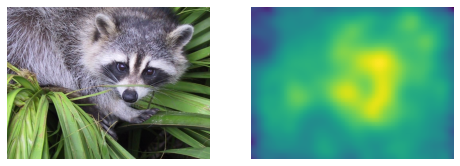

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch

DEVICE = 'cuda'

# you can use DeepGazeI or DeepGazeIIE
model_dg1 = deepgaze_pytorch.DeepGazeI(pretrained=True).to(DEVICE)

image = face()

# load precomputed centerbias log density (from MIT1003) over a 1024x1024 image
# you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
centerbias_template = np.load('centerbias_mit1003.npy')
# rescale to match image size
centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
centerbias -= logsumexp(centerbias)

image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

log_density_prediction = model_dg1(image_tensor, centerbias_tensor)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axs[0].imshow(image)
#axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
#axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
axs[0].set_axis_off()
axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0])  # first image in batch, first (and only) channel
#axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
#axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
axs[1].set_axis_off()

In [2]:
import torch
import numpy as np
import helper_consol as helper
import pandas as pd
import pingouin as pg
import rsatoolbox
import torchvision
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
from sklearn import preprocessing
import matplotlib.pyplot as plt



/home/pranjul/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/pranjul/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


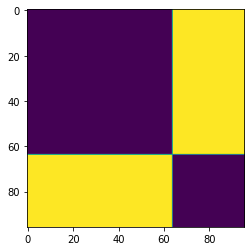

In [3]:
# pareidolia hypothesis - faces and pareidolia are same
# all distances are 0 between and within faces and pareidolia, but 1 between faces/pareidolia and objects
a = np.zeros((32,32))
b = np.zeros((32,32))
c = np.ones((32,32))
d = np.zeros((32,32))
e = np.zeros((32,32))
f = np.ones((32,32))
g = np.ones((32,32))
h = np.ones((32,32))
i = np.zeros((32,32))
hypo_1 = np.bmat([[a, b, c], [d, e, f], [g, h, i]])
plt.imshow(hypo_1)

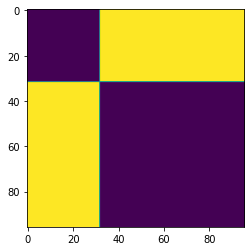

In [4]:
# face hypothesis - objects and pareidolia are same
# all distances are 0 between and within objects and pareidolia, but 1 between objects/pareidolia and faces
a = np.zeros((32,32))
b = np.ones((32,32))
c = np.ones((32,32))
d = np.ones((32,32))
e = np.zeros((32,32))
f = np.zeros((32,32))
g = np.ones((32,32))
h = np.zeros((32,32))
i = np.zeros((32,32))
hypo_2 = np.bmat([[a, b, c], [d, e, f], [g, h, i]])
plt.imshow(hypo_2)

In [5]:
network_name = 'face_inanimate_400k_facesconsolidated'
config = helper.Config(config_file='./configs/vgg/' + network_name + '.yaml')
model, ckpt_data = config.get_model(pretrained=True, ngpus=1, dataParallel=False, epoch=110, consol=True)
# model, ckpt_data = config.get_model(pretrained=True, ngpus=1, dataParallel=True, epoch=-1)
model = model.cuda()

Restored from: ../../../raid/katha/BranchingNets/checkpoints/vgg/face_inanimate_400k_facesconsolidated/epoch_110.pth.tar


In [6]:
#network_name = 'face_inanimate_400k_facesconsolidated'
#config = helper.Config(config_file='./configs/vgg/' + network_name + '.yaml')
#model, ckpt_data = config.get_model(pretrained=True, ngpus=1, dataParallel=False, epoch=110, consol=True)
# model, ckpt_data = config.get_model(pretrained=True, ngpus=1, dataParallel=True, epoch=-1)
model_dg1 = model_dg1.cuda()

'''
# Define the layer(s) you want to extract activations from
layers = [model.module.features[1], model.module.features[3], model.module.features[6],
          model.module.features[8], model.module.features[11], model.module.features[13],
          model.module.features[15], model.module.features[18], model.module.features[20],
          model.module.features[22], model.module.features[25], model.module.features[27],
          model.module.features[29], model.module.classifier[1], model.module.classifier[4]]


layers = [model.features[1], model.features[3], model.features[6],
          model.features[8], model.features[11], model.features[13],
          model.features[15], model.features[18], model.features[20],
          model.features[22], model.features[25], model.features[27],
          model.features[29], model.classifier[1], model.classifier[4]]
'''

layers = [model_dg1.features.features[1].features[1], model_dg1.features.features[1].features[4],
         model_dg1.features.features[1].features[7], model_dg1.features.features[1].features[9],
         model_dg1.features.features[1].features[11], model_dg1.features.features[1].classifier[2],
         model_dg1.features.features[1].classifier[5], model_dg1.readout_network.conv0,
         model_dg1.finalizer.gauss]


# Register forward hooks to the selected layers
activation = {}

def get_activation(name):
    def hook(model_dg1, input, output):
        activation[name] = output.detach()
    return hook

for i, layer in enumerate(layers):
    layer.register_forward_hook(get_activation(f'layer_{i+1}'))

In [7]:
bts_no = 5
folder_dir = ['/home/pranjul/DeepGaze/all_images_net_input/']

validator = helper.Validator(name='things_validator',
                             model=model,
                             batch_size=10,
                             data_dir=folder_dir,
                             ngpus=1,
                             workers=4,
                             task=None,
                             max_samples={'all_images_net_input': 32},
                             maxout=True,
                             read_seed=0,
                             shuffle=False,
                             data_subdir='test',
                             includePaths=True)

num_imgs = len(validator.dataset)
centerbias_template = np.load('centerbias_mit1003.npy')

img_act = []
spearmanr_values_hypo_1_bts, spearmanr_values_hypo_2_bts = [], []

for i, image in enumerate(validator.dataset):
        
    filename = image[-1].split('/')[-1]
    image = image[0].unsqueeze(0).cuda()
    
    
    # rescale to match image size
    centerbias = zoom(centerbias_template, (image.shape[2]/centerbias_template.shape[0], image.shape[3]/centerbias_template.shape[1]), order=0, mode='nearest')
    # renormalize log density
    centerbias -= logsumexp(centerbias)

    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    # Forward pass the image through the model
    output = model_dg1(image, centerbias_tensor)

    # Retrieve the extracted activations
    activations = [activation[f'layer_{i+1}'] for i in range(len(layers))]

    # Print out the extracted activations
    for j, act in enumerate(activations):
        print(f"Layer {j+1} activation shape for {filename}: {act.shape}")
        act = act.cpu().detach().numpy().squeeze()
        act = np.reshape(act, (np.prod(act.shape[0:])))
        img_act.append(np.array(act))


for boot_itr in range(bts_no):
    
    print("boot_itr: ", boot_itr + 1)
    
    np.random.seed(boot_itr)

    randomRows_0 = []
    randomRows_1 = []
    randomRows_2 = []

    randomRows_0 = np.random.choice(np.arange(0, 32), size=np.arange(32).shape, replace=True)
    randomRows_1 = np.random.choice(np.arange(32, 64), size=np.arange(32).shape, replace=True)
    randomRows_2 = np.random.choice(np.arange(64, 96), size=np.arange(32).shape, replace=True)
    #print(randomRows)

    bootstrap_idx = [*randomRows_0, *randomRows_1, *randomRows_2]
    # print(bootstrap_idx)

    
    img_act_layer = []
    dist_metric_layers_dual_task_fc = []
    
    for i in range(len(layers)):
        for j in bootstrap_idx:
            img_act_layer.append(img_act[i + (j*len(layers))])

    for i in range(len(layers)):
        dist_metric = 1 - np.corrcoef(np.array(img_act_layer[i*96:(i+1)*96]))
        dist_metric_layers_dual_task_fc.append(dist_metric[np.triu_indices(96, k = 1)])


    data = np.vstack([dist_metric_layers_dual_task_fc, 
                      np.array(hypo_1[np.triu_indices(96, k = 1)]),
                       np.array(hypo_2[np.triu_indices(96, k = 1)])
                   ])

    # print(np.shape(data))
    df = pd.DataFrame(data=data.T)

    col_names = []

    for i in range(len(layers)):
        col_names.append('layer_' + str(i + 1))

    col_names.extend(('hypo_1', 'hypo_2'))
    df.columns = col_names

    spearmanr_values_hypo_1, spearmanr_values_hypo_2 = [], []
    layer_no = np.arange(1, len(layers)+1)

    for i in range(len(layers)):

        zero_indices = df.loc[df['layer_'+ str(i + 1)] == 0].index 
        df_0_removed = df.drop(zero_indices)
        
        spearmanr_values_hypo_1.append(pg.partial_corr(data=df_0_removed, x='layer_' + str(i + 1), y='hypo_1', covar=['hypo_2'], method='spearman').round(3)['r'][0])
        spearmanr_values_hypo_2.append(pg.partial_corr(data=df_0_removed, x='layer_' + str(i + 1), y='hypo_2', covar=['hypo_1'], method='spearman').round(3)['r'][0])
        
    spearmanr_values_hypo_1_bts.append(np.array(spearmanr_values_hypo_1))
    spearmanr_values_hypo_2_bts.append(np.array(spearmanr_values_hypo_2))
    
#np.save('spearmanr_values_hypo_1_FC_bootstrap_new_2hypos.npy', np.array(spearmanr_values_hypo_1_bts))
#np.save('spearmanr_values_hypo_2_FC_bootstrap_new_2hypos.npy', np.array(spearmanr_values_hypo_2_bts))

'''
# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
plt.plot(layer_no, spearmanr_values_hypo_1, '-o', label='Faces~Pareidolia', markersize=10)
plt.plot(layer_no, spearmanr_values_hypo_2, '-o', label='Pareidolia~Objects', markersize=10)
plt.plot(layer_no, spearmanr_values_hypo_3, '-o', label='Faces~Objects', markersize=10)

plt.xticks(layer_no, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xticklabels(layer_no)
plt.ylabel('Partial spearmanr (rho)', fontsize=18)
plt.yticks(np.arange(-0.15, 0.65, 0.05))
leg = plt.legend(loc = 2, prop={'size': 15})
leg.get_frame().set_edgecolor('k')
fig.set_size_inches(14.,8.)
#plt.savefig('3_hypos_partial_spearman.png', dpi=600)

plt.show()
'''


read_seed: 0

Frequency of classes:
[[ 0  1  2]
 [32 32 32]]

Layer 1 activation shape for face01.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face01.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face01.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face01.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face01.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for face01.png: torch.Size([1, 4096])
Layer 7 activation shape for face01.png: torch.Size([1, 4096])
Layer 8 activation shape for face01.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for face01.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for face02.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face02.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face02.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face02.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face02.png: torch.Size([1, 2

Layer 1 activation shape for face15.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face15.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face15.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face15.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face15.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for face15.png: torch.Size([1, 4096])
Layer 7 activation shape for face15.png: torch.Size([1, 4096])
Layer 8 activation shape for face15.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for face15.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for face16.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face16.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face16.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face16.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face16.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for face16.png: torch.Size(

Layer 1 activation shape for face29.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face29.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face29.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face29.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face29.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for face29.png: torch.Size([1, 4096])
Layer 7 activation shape for face29.png: torch.Size([1, 4096])
Layer 8 activation shape for face29.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for face29.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for face30.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for face30.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for face30.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for face30.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for face30.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for face30.png: torch.Size(

Layer 1 activation shape for 26.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 26.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 26.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 26.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 26.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 26.png: torch.Size([1, 4096])
Layer 7 activation shape for 26.png: torch.Size([1, 4096])
Layer 8 activation shape for 26.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for 26.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for 34.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 34.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 34.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 34.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 34.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 34.png: torch.Size([1, 4096])
Layer 7 activation shape for 34.png: torch.Size([

Layer 1 activation shape for 74.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 74.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 74.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 74.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 74.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 74.png: torch.Size([1, 4096])
Layer 7 activation shape for 74.png: torch.Size([1, 4096])
Layer 8 activation shape for 74.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for 74.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for 75.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 75.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 75.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 75.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 75.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 75.png: torch.Size([1, 4096])
Layer 7 activation shape for 75.png: torch.Size([

Layer 1 activation shape for 17_match.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 17_match.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 17_match.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 17_match.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 17_match.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 17_match.png: torch.Size([1, 4096])
Layer 7 activation shape for 17_match.png: torch.Size([1, 4096])
Layer 8 activation shape for 17_match.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for 17_match.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for 20_match.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 20_match.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 20_match.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 20_match.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 20_match.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape

Layer 1 activation shape for 59_match.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 59_match.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 59_match.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 59_match.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 59_match.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape for 59_match.png: torch.Size([1, 4096])
Layer 7 activation shape for 59_match.png: torch.Size([1, 4096])
Layer 8 activation shape for 59_match.png: torch.Size([1, 1, 28, 28])
Layer 9 activation shape for 59_match.png: torch.Size([1, 1, 56, 56])
Layer 1 activation shape for 64_match.png: torch.Size([1, 64, 27, 27])
Layer 2 activation shape for 64_match.png: torch.Size([1, 192, 13, 13])
Layer 3 activation shape for 64_match.png: torch.Size([1, 384, 6, 6])
Layer 4 activation shape for 64_match.png: torch.Size([1, 256, 6, 6])
Layer 5 activation shape for 64_match.png: torch.Size([1, 256, 6, 6])
Layer 6 activation shape

"\n# Plotting\nfig = plt.figure(figsize=(14, 8))\nax = fig.add_subplot(111)\nplt.plot(layer_no, spearmanr_values_hypo_1, '-o', label='Faces~Pareidolia', markersize=10)\nplt.plot(layer_no, spearmanr_values_hypo_2, '-o', label='Pareidolia~Objects', markersize=10)\nplt.plot(layer_no, spearmanr_values_hypo_3, '-o', label='Faces~Objects', markersize=10)\n\nplt.xticks(layer_no, fontsize=18)\nplt.yticks(fontsize=18)\nax.set_xticklabels(layer_no)\nplt.ylabel('Partial spearmanr (rho)', fontsize=18)\nplt.yticks(np.arange(-0.15, 0.65, 0.05))\nleg = plt.legend(loc = 2, prop={'size': 15})\nleg.get_frame().set_edgecolor('k')\nfig.set_size_inches(14.,8.)\n#plt.savefig('3_hypos_partial_spearman.png', dpi=600)\n\nplt.show()\n"

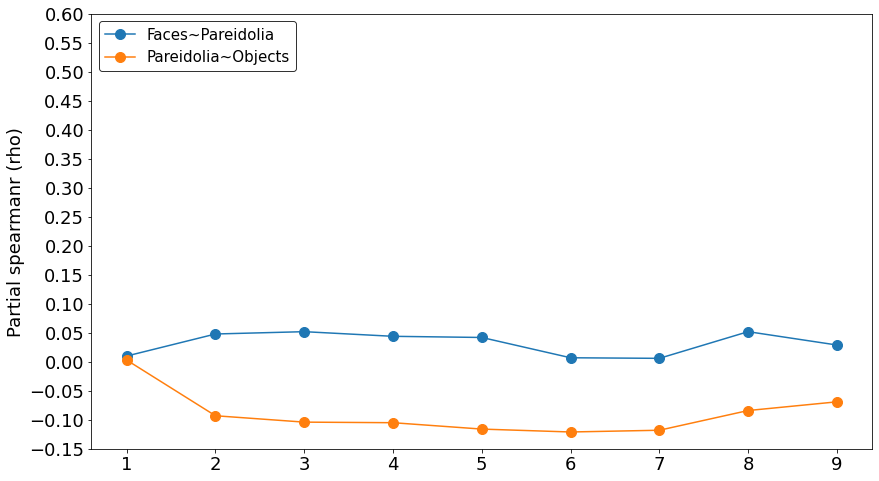

In [8]:
num_imgs = len(validator.dataset)

img_act = []

for i, image in enumerate(validator.dataset):
        
    filename = image[-1].split('/')[-1]
    image = image[0].unsqueeze(0).cuda()

    # rescale to match image size
    centerbias = zoom(centerbias_template, (image.shape[2]/centerbias_template.shape[0], image.shape[3]/centerbias_template.shape[1]), order=0, mode='nearest')
    # renormalize log density
    centerbias -= logsumexp(centerbias)

    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

    # Forward pass the image through the model
    output = model_dg1(image, centerbias_tensor)

    # Retrieve the extracted activations
    activations = [activation[f'layer_{i+1}'] for i in range(len(layers))]

    # Print out the extracted activations
    for j, act in enumerate(activations):
        # print(f"Layer {j+1} activation shape for {filename}: {act.shape}")
        act = act.cpu().detach().numpy().squeeze()
        act = np.reshape(act, (np.prod(act.shape[0:])))
        img_act.append(np.array(act))

img_act_layer = []
dist_metric_layers_dual_task_fc = []


for i in range(len(layers)):
    for j in range(96):
        img_act_layer.append(img_act[i + (j*len(layers))])

for i in range(len(layers)):
    dist_metric = 1 - np.corrcoef(np.array(img_act_layer[i*96:(i+1)*96]))
    dist_metric_layers_dual_task_fc.append(dist_metric[np.triu_indices(96, k = 1)])

#np.save('dist_metric_layers_dual_task_fc_2_hypos.npy', np.array(dist_metric_layers_dual_task_fc))

data = np.vstack([dist_metric_layers_dual_task_fc, 
                np.array(hypo_1[np.triu_indices(96, k = 1)]),
               np.array(hypo_2[np.triu_indices(96, k = 1)]),
               ])

# print(np.shape(data))
df = pd.DataFrame(data=data.T)

col_names = []

for i in range(len(layers)):
    col_names.append('layer_' + str(i + 1))

col_names.extend(('hypo_1', 'hypo_2'))
df.columns = col_names

spearmanr_values_hypo_1, spearmanr_values_hypo_2 = [], []
layer_no = np.arange(1, len(layers)+1)

for i in range(len(layers)):

    spearmanr_values_hypo_1.append(pg.partial_corr(data=df, x='layer_' + str(i + 1), y='hypo_1', covar=['hypo_2'], method='spearman').round(3)['r'][0])
    spearmanr_values_hypo_2.append(pg.partial_corr(data=df, x='layer_' + str(i + 1), y='hypo_2', covar=['hypo_1'], method='spearman').round(3)['r'][0])

#np.save('inanimate_vgg_large_spearmanr_values_hypo_1_2hypos.npy', np.array(spearmanr_values_hypo_1))
#np.save('inanimate_vgg_large_spearmanr_values_hypo_2_2hypos.npy', np.array(spearmanr_values_hypo_2))

#face_inanimate_400k_seed_spearmanr_values_hypo_1_bootstrap_new_2hypos

# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
plt.plot(layer_no, spearmanr_values_hypo_1, '-o', label='Faces~Pareidolia', markersize=10)
plt.plot(layer_no, spearmanr_values_hypo_2, '-o', label='Pareidolia~Objects', markersize=10)

plt.xticks(layer_no, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xticklabels(layer_no)
plt.ylabel('Partial spearmanr (rho)', fontsize=18)
plt.yticks(np.arange(-0.15, 0.65, 0.05))
leg = plt.legend(loc = 2, prop={'size': 15})
leg.get_frame().set_edgecolor('k')
fig.set_size_inches(14.,8.)
#plt.savefig('3_hypos_partial_spearman.png', dpi=600)

plt.show()


In [9]:
face_vgg_large_spearmanr_values_hypo_1 = spearmanr_values_hypo_1_bts
face_vgg_large_spearmanr_values_hypo_1 = np.reshape(face_vgg_large_spearmanr_values_hypo_1, (bts_no, len(layers)))
face_vgg_large_spearmanr_values_hypo_2 = spearmanr_values_hypo_2_bts
face_vgg_large_spearmanr_values_hypo_2 = np.reshape(face_vgg_large_spearmanr_values_hypo_2, (bts_no, len(layers)))

In [10]:
mean_1 = spearmanr_values_hypo_1
mean_2 = spearmanr_values_hypo_2

std_1 = []
std_2 = []


for i in range(len(layers)):
    std_1.append(np.std(face_vgg_large_spearmanr_values_hypo_1, axis = 0)[i])
    std_2.append(np.std(face_vgg_large_spearmanr_values_hypo_2, axis = 0)[i])

std_1 = np.array(std_1)
std_2 = np.array(std_2)

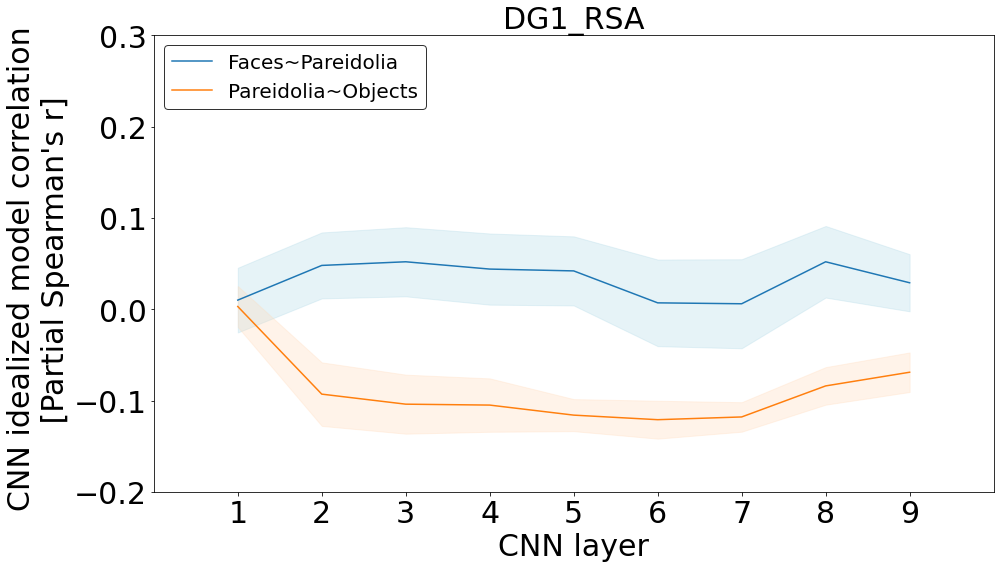

In [11]:
# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
#plt.axis('on')
#ax = plt.gca()
#plt.plot(layer_no, mean_1, '-o', label='Faces~Pareidolia', markersize=10)
#plt.plot(layer_no, mean_2, '-o', label='Pareidolia~Objects', markersize=10)
#plt.errorbar(layer_no, mean_1, yerr=[confidence_interval_1_0, confidence_interval_1_1], fmt='-o', color = 'tab:blue', capsize=8, label='Faces~Pareidolia', markersize=2)
#plt.errorbar(layer_no, mean_2, yerr=[confidence_interval_2_0, confidence_interval_2_1], fmt='-o', color = 'tab:orange', capsize=8, label='Pareidolia~Objects', markersize=3)
#plt.errorbar(layer_no, mean_3, yerr=[confidence_interval_3_0, confidence_interval_3_1], fmt='-o', color = 'tab:green', capsize=8, label='Objects~Faces', markersize=3)

plt.plot(layer_no, mean_1, color = 'tab:blue', label='Faces~Pareidolia')
plt.fill_between(layer_no, mean_1-std_1, mean_1+std_1, color = 'lightblue', alpha=.3)

plt.plot(layer_no, mean_2, color = 'tab:orange', label='Pareidolia~Objects')
plt.fill_between(layer_no, mean_2-std_2, mean_2+std_2, color = 'peachpuff', alpha=.3)

# plt.plot(layer_no, mean_3, color = 'tab:green', label='Objects~Faces')
# plt.fill_between(layer_no, mean_3-std_3, mean_3+std_3, color = 'lightgreen', alpha=.3)

#plt.plot(layer_no, spearmanr_values_hypo_3, '-o', label='Faces~Objects', markersize=10)
#plt.axhline(y=0.5, color='r', linestyle='--', label='Random chance')
#plt.axvline(x=4, color='k', linestyle='--')
#plt.axvline(x=13,color='k', linestyle='--')

plt.xticks(layer_no, fontsize=30)
plt.yticks(fontsize=30)
#ax.tick_params(axis='both', which='major')
ax.set_xticklabels(layer_no)
plt.axis([0, len(layers)+1, -0.2, 0.3])
plt.xlabel('CNN layer', fontsize=30)
plt.ylabel("CNN idealized model correlation \n [Partial Spearman's r]", fontsize=30)
plt.title('DG1_RSA', fontsize=30)
#ax.grid(which='both')
#ax.grid(which='minor', alpha=0.2)
#ax.grid(which='major', alpha=0.5)
#ax.grid(color='k', alpha=1, linestyle='--')
#plt.legend(loc = 4, prop={'size': 20})
leg = plt.legend(loc = 2, prop={'size': 20})
leg.get_frame().set_edgecolor('k')
#fig.set_size_inches(14.,8.)
plt.tight_layout()
plt.savefig('DG1_RSA.png', dpi=600)

plt.show()